In [1]:
import os
import cv2
import numpy as np
import random
import pickle

# Load images from a directory
def load_images_from_dir(directory):
    images = []
    labels = []
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".bmp"):
            img = cv2.imread(directory + "/" + filename, cv2.IMREAD_GRAYSCALE)
            # print(img.shape)
            # img = cv2.resize(img, (64, 64))
            images.append(img)
            labels.append(filename[:3])
            count += 1
    # print(count)
    return images, labels

imgs, labels = load_images_from_dir("/Users/gvssriram/Desktop/MS/sem-3/Biometrics/Project/Datasets/IITD Palmprint V1/Segmented/Left")

In [2]:
labels

['214',
 '108',
 '089',
 '031',
 '209',
 '115',
 '074',
 '150',
 '052',
 '176',
 '017',
 '133',
 '216',
 '008',
 '169',
 '152',
 '117',
 '015',
 '050',
 '194',
 '096',
 '028',
 '210',
 '013',
 '172',
 '056',
 '154',
 '070',
 '111',
 '035',
 '090',
 '192',
 '049',
 '128',
 '170',
 '135',
 '229',
 '037',
 '072',
 '092',
 '190',
 '037',
 '072',
 '170',
 '054',
 '135',
 '011',
 '212',
 '049',
 '192',
 '090',
 '154',
 '111',
 '013',
 '056',
 '149',
 '210',
 '028',
 '096',
 '194',
 '015',
 '131',
 '050',
 '174',
 '076',
 '152',
 '033',
 '117',
 '189',
 '230',
 '169',
 '216',
 '094',
 '196',
 '176',
 '133',
 '209',
 '031',
 '074',
 '089',
 '108',
 '069',
 '069',
 '214',
 '089',
 '017',
 '133',
 '052',
 '176',
 '074',
 '150',
 '031',
 '115',
 '094',
 '196',
 '008',
 '230',
 '189',
 '174',
 '131',
 '033',
 '076',
 '096',
 '194',
 '210',
 '149',
 '035',
 '154',
 '070',
 '172',
 '056',
 '137',
 '013',
 '212',
 '128',
 '049',
 '156',
 '113',
 '011',
 '229',
 '054',
 '190',
 '092',
 '092',
 '190',


In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Cropping2D
import matplotlib.pyplot as plt

# Set constants
input_shape = (150, 150, 1)
latent_dim = 64

# # Load MNIST dataset
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), 28, 28, 1))
# x_test = x_test.reshape((len(x_test), 28, 28, 1))

# Split the data into training and testing using 80-20 split ratio and shuffle the data and labels
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.asarray(imgs), labels, test_size=0.2, random_state=42, shuffle=True, stratify=labels)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 150, 150, 1))
x_test = x_test.reshape((len(x_test), 150, 150, 1))

# Encoder
input_img = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x) # 75 x 75
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x) # 38 x 38
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x) # 19 x 19
encoded = Flatten()(x)  # Flatten to get the encoded representation

# Encoder Model
encoder = Model(input_img, encoded, name="encoder")
encoder.summary()

# Decoder
decoder_input = Input(shape=(encoded.shape[1],))
x = Reshape((19, 19, 128))(decoder_input) # Adjust based on pooling
x = Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
decoded = Cropping2D(cropping=((1, 1), (1, 1)))(decoded)

# Decoder Model
decoder = Model(decoder_input, decoded, name="decoder")
decoder.summary()

# Autoencoder
# autoencoder = Model(input_img, decoded)
# Connect the encoder and decoder
autoencoder_output = decoder(encoder(input_img))
autoencoder = Model(input_img, autoencoder_output)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['mae', 'mse'])

# callbacks
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.001)

callbacks = [early_stopping, tensorboard, reduce_lr]

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,672 (362.00 KB)

 Trainable params: 92,672 (362.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 19, 19, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 38, 38, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 76, 76, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 76, 76, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 152, 152, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 152, 152, 1)    │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 150, 150, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,129 (938.00 KB)

 Trainable params: 240,129 (938.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Train the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)

# Save the model
autoencoder.save("autoencoder.keras")
encoder.save("encoder.keras")
decoder.save("decoder.keras")

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - loss: 1.8312 - mae: 0.2232 - mse: 0.0692 - val_loss: 0.6257 - val_mae: 0.1304 - val_mse: 0.0249 - learning_rate: 0.0100
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 0.6267 - mae: 0.1286 - mse: 0.0251 - val_loss: 0.6208 - val_mae: 0.1163 - val_mse: 0.0229 - learning_rate: 0.0100
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 0.6201 - mae: 0.1191 - mse: 0.0225 - val_loss: 0.6190 - val_mae: 0.1209 - val_mse: 0.0219 - learning_rate: 0.0100
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - loss: 0.6165 - mae: 0.1150 - mse: 0.0209 - val_loss: 0.6350 - val_mae: 0.1485 - val_mse: 0.0293 - learning_rate: 0.0100
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - loss: 0.6194 - mae: 0.1210 - mse: 0.0224 - val_loss: 0.6145 - val_mae: 0.1157 - val_mse: 0.0197 - learning_rate: 0.0100
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - loss: 0.6102 - mae: 0.1056 - mse: 0.0180 - val_loss: 0.6028 - val_mae: 0.0964 - val_mse: 0.0146 - le

In [5]:
autoencoder = tf.keras.models.load_model("autoencoder.keras")
encoder = tf.keras.models.load_model("encoder.keras")
decoder = tf.keras.models.load_model("decoder.keras")

In [6]:
# Display the architecture of the autoencoder
autoencoder.summary()

# Plot the model architecture
# tf.keras.utils.plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
# plt.imshow(plt.imread('autoencoder.png'))

# Create a separate encoder model
# encoder = Model(input_img, encoded)

# # Create a separate decoder model
# encoded_input = Input(shape=(latent_dim,))
# decoder_layers = autoencoder.layers[-4:]
# decoder = Model(encoded_input, decoder_layers[0](encoded_input))
# for layer in decoder_layers[1:]:
#     decoder = Model(encoded_input, layer(decoder.output))

# Display the architecture of the encoder
encoder.summary()

# Plot the model architecture
# tf.keras.utils.plot_model(encoder, to_file='encoder.png', show_shapes=True)
# plt.imshow(plt.imread('encoder.png'))

# Display the architecture of the decoder
decoder.summary()

# Plot the model architecture
# tf.keras.utils.plot_model(decoder, to_file='decoder.png', show_shapes=True)
# plt.imshow(plt.imread('decoder.png'))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 46208)          │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 150, 150, 1)    │       240,129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 998,405 (3.81 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 665,604 (2.54 MB)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,672 (362.00 KB)

 Trainable params: 92,672 (362.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 19, 19, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 38, 38, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 76, 76, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 76, 76, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 152, 152, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 152, 152, 1)    │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 150, 150, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,129 (938.00 KB)

 Trainable params: 240,129 (938.00 KB)

 Non-trainable params: 0 (0.00 B)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step


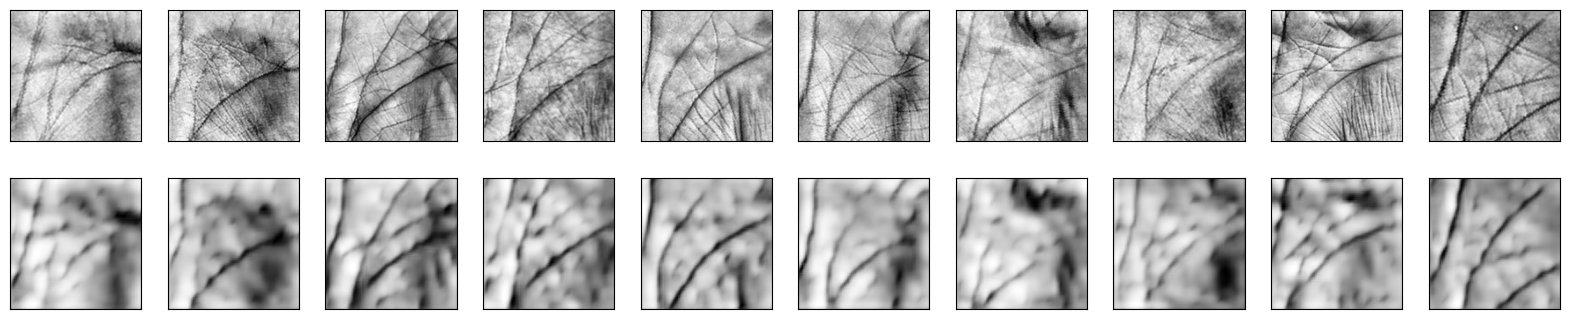

In [7]:
# Encode and decode some digits
encoded_imgs = autoencoder.predict(x_test)
decoded_imgs = autoencoder.predict(encoded_imgs)

# Display the original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(150, 150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(150, 150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
import numpy as np

# Encoded images are weight templates
encoded_imgs = encoder.predict(x_train)
encoded_imgs

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


array([[0.        , 0.05113373, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07011382, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01827369, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02361108, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [9]:
encoded_imgs.shape

(1040, 46208)

In [10]:
decoded_imgs = decoder.predict(encoded_imgs)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step


In [11]:
decoded_imgs.shape

(1040, 150, 150, 1)

In [12]:
y_train = tf.keras.utils.to_categorical(y_train)

In [13]:
# Softmax Classifier
input_layer = Input(shape=(encoded_imgs.shape[1],))
output = Dense(units=y_train.shape[1], activation='softmax')(input_layer)
clf = Model(input_layer, output)
clf.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
clf.summary()

# Train the classifier
clf.fit(encoded_imgs, y_train, epochs=200, batch_size=128, validation_split=0.1, shuffle=True, verbose=1, callbacks=[reduce_lr])
# hist = clf.fit(X_tv, y_tv, batch_size=64, epochs=50, validation_split=0.1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 231)            │    10,674,279 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,674,279 (40.72 MB)

 Trainable params: 10,674,279 (40.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.0798 - loss: 6.0018 - val_accuracy: 0.2981 - val_loss: 4.2308 - learning_rate: 0.0100
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5880 - loss: 2.7803 - val_accuracy: 0.5577 - val_loss: 2.5437 - learning_rate: 0.0100
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9001 - loss: 0.9849 - val_accuracy: 0.6538 - val_loss: 1.9949 - learning_rate: 0.0100
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9643 - loss: 0.3699 - val_accuracy: 0.7115 - val_loss: 1.5126 - learning_rate: 0.0100
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9959 - loss: 0.1634 - val_accuracy: 0.7115 - val_loss: 1.4840 - learning_rate: 0.0100
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9952 - loss: 0.0850 - val_accuracy: 0.7115 - val_loss: 1.4247 - learning_rate: 0.0100
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9956 - loss: 0.0507 - val_accuracy: 